Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [82]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
#%matplotlib qt 
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [6]:
model_name = 'psm'
#model_name = 'psm_simplified'

model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [7]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')
_pi = sympy.pi

dh = []
springs = []
friction_type = []

if (model_name == 'psm_simplified'):   
    q8 = 1.0186 * q5
    q9 = -0.8306 * q5 + 1.2178 * q6
    q10 = -0.8306 *q5 + 1.2178 * q7
    
    l_2L1 = 96*0.001
    l_2L2 = 516*0.001
    l_2L3 = 40.09*0.001
    
    l_2H1 = 144.54*0.001
    l_2H2 = 38.08*0.001
    
    l_3 = 40.09*0.001
    
    l_RCC = 431.8*0.001
    l_tool = 416.2*0.001
    l_pitch2yaw = 9.1*0.001
    
    M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
    M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
    
    L_b = 0
    L_1 = 1
    L_20 = 2
    L_21 = 3
    L_22 = 4
#     L_23 = 5
    L_24 = 5
#     L_25 = 6
    L_30 = 6
    L_31 = 7
    L_4 = 8
    L_5 = 9
    L_6 = 10
    L_7 = 11
    M_6 = 12
    M_7 = 13
    F_67 = 14
    
    
    x = [None]*15
    x[0]  = (L_b,  -1,   [L_1, M_6, M_7, F_67], 0,           0,      0,              0,         False, False, False) # Base
    
    
    x[1]  = (L_1,  L_b,  [L_20],                0,           _pi/2,  0,              q1+_pi/2,  True,  False, True) # Yaw
    x[2]  = (L_20, L_1,  [L_21, L_31],          0,           -_pi/2, 0,              q2-_pi/2,  True,  False, True) # -- Intermediate
    x[3]  = (L_21, L_20, [L_22],                l_2L3,       0,      0,              _pi/2,     False, False, False) # Pitch Back
    x[4]  = (L_22, L_21, [L_24, L_30],          l_2H1,       0,      0,              -q2+_pi/2, True,  False, False) # Pitch Front                                    )
    #x[5]  = (L_23, L_21, [],                    l_2H1+l_2H2, 0,      0,              -q2+_pi/2, True,  False, False)    # Intermediate
    x[5]  = (L_24, L_22, [L_30],                l_2L2,       0,      0,              q2,        True,  False, False)    # Pitch Bottom
    #x[7]  = (L_25, L_22, [],                    l_2L1,       0,      0,              q2+_pi,    True,  False, False)    # Pitch Top
    x[6]  = (L_30, L_24, [L_4],                 l_3,         -_pi/2,  q3-l_RCC+l_2H1, 0,         True,  False, True)    # Pitch End
    x[7]  = (L_31, L_20, [],                    l_2L3,       -_pi/2, q3,             0,         True,  False, False)    # Main Insertion
    x[8] = (L_4,  L_30, [L_5],                  0,           0,      l_tool,         q4,        False, True,  True) # Intermediate Counterweight
    x[9] = (L_5,  L_4,  [L_6, L_7],             0,           _pi/2,  0,              q8+_pi/2,  False, True,  True) # Counterweight
    x[10] = (L_6,  L_5,  [],                    l_pitch2yaw, -_pi/2, 0,              q9+_pi/2,  False, False,  True) # Tool Roll 
    x[11] = (L_7,  L_5,  [],                    l_pitch2yaw, -_pi/2, 0,              q10+_pi/2,  False, False,  True) # Tool Pitch
    
    x[12] = (M_6,  L_b,  [],                    0,           0,      0,              q6,        False, True,  True) # Tool Yaw1 inert
    x[13] = (M_7,  L_b,  [],                    0,           0,      0,              q7,        False, True,  True) # Tool Yaw2 inert
    x[14] = (F_67, L_b,  [],                    0,           0,      0,              q10-q9,    False, False, True) # q6 q7 coupled friction
    
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    springs = [-q4]
    print(model_name)
elif (model_name == 'psm'):
    
    q8 = 1.0186 * q5
    q9 = -0.8306 * q5 + 1.2178 * q6
    q10 = -0.8306 *q5 + 1.2178 * q7
    
    l_2L1 = 96*0.001
    l_2L2 = 516*0.001
    l_2L3 = 40.09*0.001
    
    l_2H1 = 144.54*0.001
    l_2H2 = 38.08*0.001
    
    l_3 = 40.09*0.001
    
    l_RCC = 431.8*0.001
    l_tool = 416.2*0.001
    l_pitch2yaw = 9.1*0.001
    
    M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
    M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
    
    L_b = 0
    L_1 = 1
    L_20 = 2
    L_21 = 3
    L_22 = 4
    L_23 = 5
    L_24 = 6
    L_25 = 7
    L_30 = 8
    L_31 = 9
    L_4 = 10
    L_5 = 11
    L_6 = 12
    L_7 = 13
    M_6 = 14
    M_7 = 15
    F_67 = 16
    
    
    x = [None]*17
    x[0]  = (L_b,  -1,   [L_1, M_6, M_7, F_67], 0,           0,      0,              0,         False, False, False) # Base
    
    
    x[1]  = (L_1,  L_b,  [L_20],                0,           _pi/2,  0,              q1+_pi/2,  True,  False, True) # Yaw
    x[2]  = (L_20, L_1,  [L_21, L_31],          0,           -_pi/2, 0,              q2-_pi/2,  True,  False, True) # -- Intermediate
    x[3]  = (L_21, L_20, [L_22, L_23],          l_2L3,       0,      0,              _pi/2,     False, False, False) # Pitch Back
    x[4]  = (L_22, L_21, [L_24, L_25, L_30],    l_2H1,       0,      0,              -q2+_pi/2, True,  False, False) # Pitch Front                                    )
    x[5]  = (L_23, L_21, [],                    l_2H1+l_2H2, 0,      0,              -q2+_pi/2, True,  False, False)    # Intermediate
    x[6]  = (L_24, L_22, [L_30],                l_2L2,       0,      0,              q2,        True,  False, False)    # Pitch Bottom
    x[7]  = (L_25, L_22, [],                    l_2L1,       0,      0,              q2+_pi,    True,  False, False)    # Pitch Top
    x[8]  = (L_30, L_24, [L_4],                 l_3,         -_pi/2,  q3-l_RCC+l_2H1, 0,         True,  False, True)    # Pitch End
    x[9]  = (L_31, L_20, [],                    l_2L3,       -_pi/2, q3,             0,         True,  False, False)    # Main Insertion
    x[10] = (L_4,  L_30, [L_5],                 0,           0,      l_tool,         q4,        False, True,  True) # Intermediate Counterweight
    x[11] = (L_5,  L_4,  [L_6, L_7],            0,           _pi/2,  0,              q8+_pi/2,  False, True,  True) # Counterweight
    x[12] = (L_6,  L_5,  [],                    l_pitch2yaw, -_pi/2, 0,              q9+_pi/2,  False, False,  True) # Tool Roll 
    x[13] = (L_7,  L_5,  [],                    l_pitch2yaw, -_pi/2, 0,              q10+_pi/2,  False, False,  True) # Tool Pitch
    
    x[14] = (M_6,  L_b,  [],                    0,           0,      0,              q6,        False, True,  True) # Tool Yaw1 inert
    x[15] = (M_7,  L_b,  [],                    0,           0,      0,              q7,        False, True,  True) # Tool Yaw2 inert
    x[16] = (F_67, L_b,  [],                    0,           0,      0,              q10-q9,    False, False, True) # q6 q7 coupled friction
    
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    springs = [-q4]
    print(model_name)
else:
    raise Exception("No robot name matches " + name)
print(friction_type)
robot_def = RobotDef(dh,
                     springs=springs,
                     dh_convention='mdh',
                     friction_type=friction_type)

psm
['Coulomb', 'viscous', 'offset']


In [26]:
M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
M_motor2model_q = np.linalg.inv(M_model2dvrk_q)*M_motor2dvrk_q
M_motor2model_q[np.abs(M_motor2model_q) < 0.0001] = 0
M_motor2model_q

matrix([[ 1.0186 ,  0.     ,  0.     ],
        [-0.8306 ,  1.21775,  0.     ],
        [-0.8306 ,  0.     ,  1.21775]])

In [27]:
robot_def.coordinates_joint_type

['R', 'R', 'P', 'R', 'R', 'R', 'R']

In [28]:
robot_def.bary_params

## Create kinematics chain

In [29]:
%time geom = Geometry(robot_def)

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
CPU times: user 11min 9s, sys: 2.19 s, total: 11min 11s
Wall time: 11min 9s


In [30]:
angle = [0, 0.0, 0, 0, 0, 0.3, 0.4]
geom.draw_geom(angle)

## Create dynamics

In [31]:
dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/14
Calculating the link kinetic energy of 2/14
Calculating the link kinetic energy of 4/14
Calculating the link kinetic energy of 5/14
Calculating the link kinetic energy of 6/14
Calculating the link kinetic energy of 7/14
Calculating joint torques...
tau of q1
tau of q2
tau of q3
tau of q4
tau of q5
tau of q6
tau of q7
Adding frictions and springs...
Add motor inertia...
Calculating regressor...
Calculating M, C and G...
Calculating base parameter...
base parameter number: 48
Creating H_b function...
Finished creating robot dynamics


In [32]:
sympy.Matrix(dyn.base_param)

⎡                                                              1.0⋅m₆         
⎢                                                                             
⎢                                                              1.0⋅m₇         
⎢                                                                             
⎢                                      0.5⋅l2y - 0.5⋅l5y + 1.0⋅l7z + 0.07227⋅m
⎢                                                                             
⎢                                     -0.5⋅l2x + 0.5⋅l5x + 1.0⋅l6x - 0.020045⋅
⎢                                                                             
⎢                                      -0.5⋅l2y + 0.5⋅l5y + 1.0⋅l6z - 0.07227⋅
⎢                                                                             
⎢                                     0.5⋅l2x - 0.5⋅l5x + 1.0⋅l7x + 0.020045⋅m
⎢                                                                             
⎢                                         -0.5⋅l1y -

In [33]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Saved {} parameters'.format(len(robot_model.base_param)))

Saved 48 parameters


---
# 3 - Excitation trajectory optimization

In [71]:
model_name = 'psm_simplified'
#model_name = 'psm'

Load Data

In [72]:
from utils import load_data
model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [73]:
#trajectory_name = 'one'
trajectory_name = 'three'
#trajectory_name = 'three'

In [75]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'

base_freq = 0.18
fourier_order = 6

joint_constraints = []
cartesian_constraints = []

if model_name == 'psm_simplified':
    q_dvrk7 = 1.2177*q7 - 1.2177*q6
#     q_mod6 = (4871*q6)/4000 - (4153*q5)/5000
#     q_mod7 = - (4153*q5)/5000 + (4871*q7)/4000
    
    q_dvrk5 = 1.0186 * q5
    q_mod6 = -0.8306 * q5 + 1.2178 * q6
    q_mod7 = -0.8306 * q5 + 1.2178 * q7
    
    joint_constraints = [(q1, -1.45, 1.45, -1.7, 1.7),
                         (q2, -0.75, 0.8, -1.7, 1.7),
                         (q3,0.07,0.235,-0.35,0.35),
                         (q4,-1.5,1.5,-2,2),
                         (q_dvrk5,-1.4,1.4,-2,2), 
                         (q_dvrk7, 0.15, 3,-3,3),
                         (q_mod7, -1.5, 1.5,-2,2),
                          (q_mod6, -1.5, 1.5,-2,2)]
else:
    raise Exception("No robot name matches " + model_name)
    
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 8
cartesian constraint number: 0
constraint number: 32
frames_constrained: []
Condition number: 197.805916082
Condition number: 197.805916082
Condition number: 137.075576931
Condition number: 161.072584089
Condition number: 179.206432626
Condition number: 208.842114932
Condition number: 231.604936067
Condition number: 320.820894879
Condition number: 330.746372173
Condition number: 407.600964447
Condition number: 570.357405485
Condition number: 547.94170681
Condition number: 513.818796385
Condition number: 510.876308993
Condition number: 509.494714565
Condition number: 245.758631766
Condition number: 247.957554442
Condition number: 254.714606925
Condition number: 259.340023299
Condition number: 266.369804767
Condition number: 286.65451569
Condition number: 287.760574794
Condition number: 295.363534051
Condition number: 302.037648748
Condition number: 315.414427119
Condition number: 330.138220297
Condition number: 333.523465007
Condition number: 334.87344084
Cond

In [76]:
reg_norm_mat = traj_optimizer.calc_normalize_mat()

## Plot optimal excitation trajectory

In [77]:
traj_optimizer.calc_frame_traj()

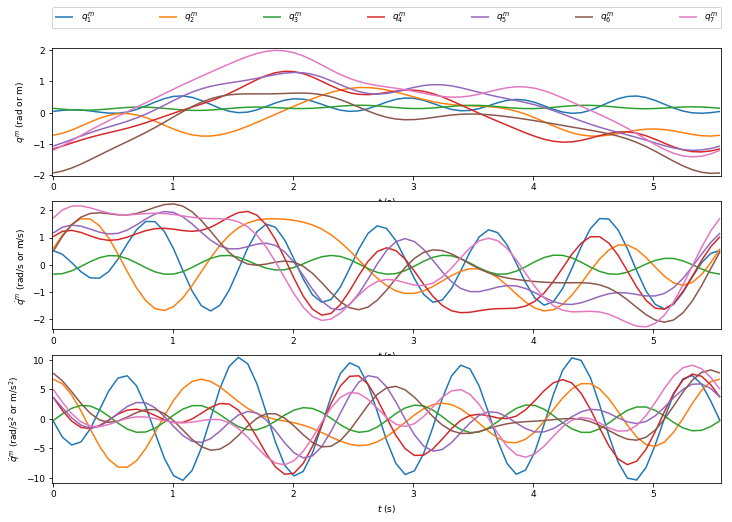

<Figure size 864x576 with 0 Axes>

In [83]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind, robot_model.coordinates)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [79]:
dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, reg_norm_mat)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

In [80]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

---
# Data processing

## Load data

In [8]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

### Load robot model

In [9]:
# Names as Arguments
model_name = 'psm'

training_trajectory_name = 'one'


model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,model_name)


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                          training_trajectory_name)
#dof, fourier_order, base_freq, traj_optimizer_result = load_data(trajectory_folder,training_trajectory_name)
     
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 7
Fourier order: 6
Base frequency: 0.18


### Load traning data set

In [10]:
# training_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 200
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (5999, 21))


### Training trajectory

In [68]:
from trajectory_optimization import FourierTraj
fourier_traj_train = FourierTraj(dof, fourier_order, base_freq, sample_num_per_period=20)
traj_plotter_train = TrajPlotter(fourier_traj_train, coordinates=robot_model.coordinates)
traj_plotter_train.plot_desired_traj(traj_optimizer_result)

### Load test data set

In [11]:
test_trajectory_name = 'two'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 200
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (5999, 21))


## Calculate filter cut-off frequency

In [12]:
# times of the highest frequency in the Fourier series
#fc_mult = 4.0

fc_mult = [5] #(good)
#fc_mult = [8, 8, 5, 3, 4, 4, 4]

#fc_mult = 4
print(base_freq)
fc = np.array(fc_mult)*base_freq* fourier_order 

print(fc)


0.18
[5.4]


## Differentiation and filtering

### Traning data

q_raw shape: (5999, 7)
plot shape: 470


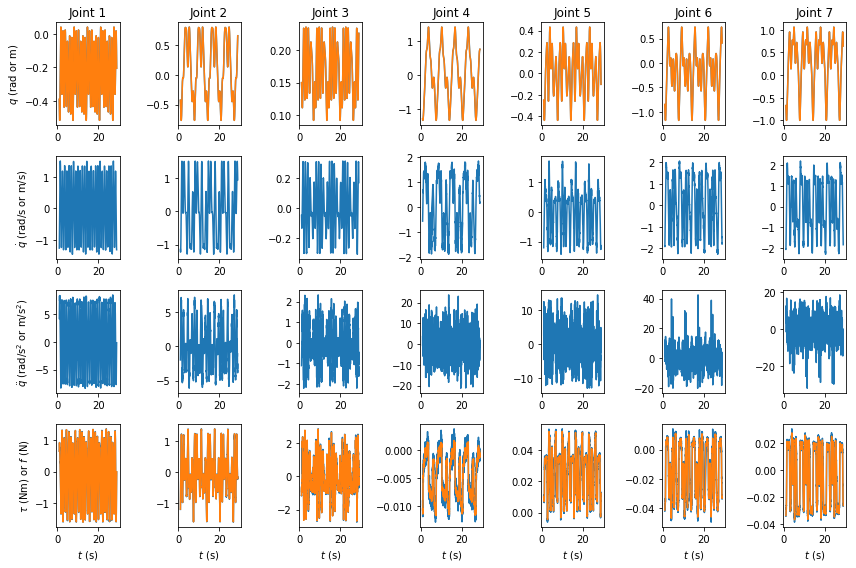

In [84]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

### Test data

q_raw shape: (5999, 7)
plot shape: 470


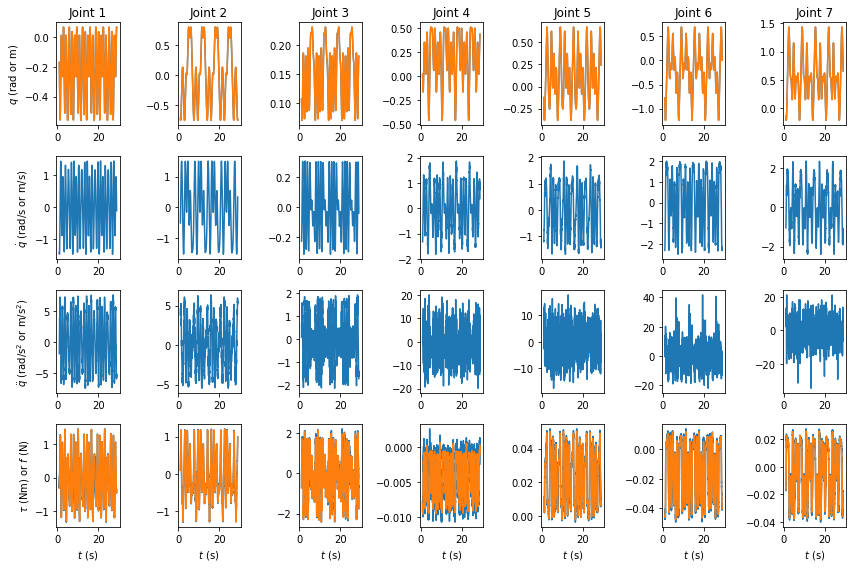

In [85]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [15]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [16]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [17]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [18]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 50
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [19]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [20]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.00040354165300893305
standard deviation of xb using OLS:
[2.10558237e-04 3.33622550e-04 1.62254635e-04 1.71967875e-04
 1.15719866e-04 1.32085838e-04 1.34671693e-03 1.34648248e-03
 8.28318928e-02 2.63767897e-04 4.35919634e-04 5.16462660e-04
 5.76291616e-04 5.93192486e-04 9.02891335e-05 3.61698769e-03
 4.55984261e-05 5.69021792e-05 3.96858047e-03 6.46017356e-04
 4.19364863e-05 5.47920648e-04 3.97173339e-05 1.27863522e-04
 2.22992468e-04 6.74626588e-04 3.59624693e-04 7.08455370e-04
 6.17585556e-03 3.14072011e-04 5.65298150e-04 6.12201281e-04
 9.07760050e-03 2.70304307e-04 1.82559493e-03 2.00549498e-04
 2.68076322e-02 2.71553210e-03 4.54604815e-04 4.69761535e-04
 3.71673747e-04 5.72218285e-04 6.07688733e-04 5.34353222e-04
 5.49635238e-04 5.92324670e-04 6.07084778e-04 5.44042437e-04
 8.57026406e-02]
percentage of standard deviation of xb using OLS: 
[5.75050339e-04 9.45164241e-04 3.76908309e-03 1.13764476e-03
 7.70891911e-03 7.33655208e-03 2.5569758

### Plot measured torque and predicted torque

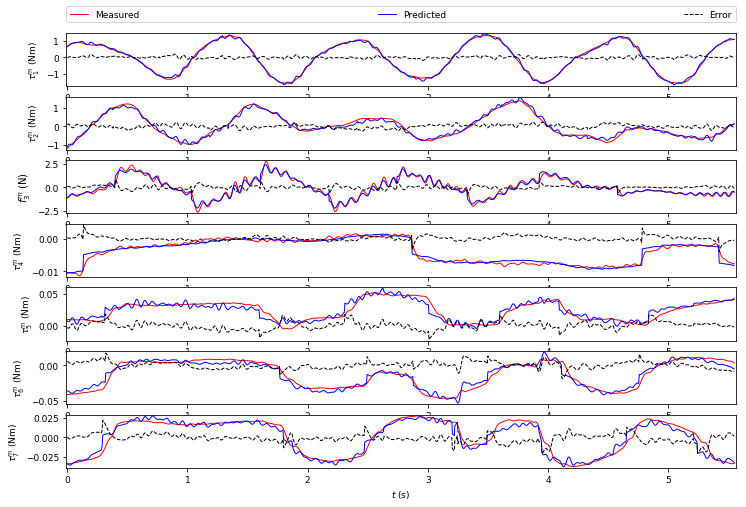

In [86]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on the test set

In [22]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

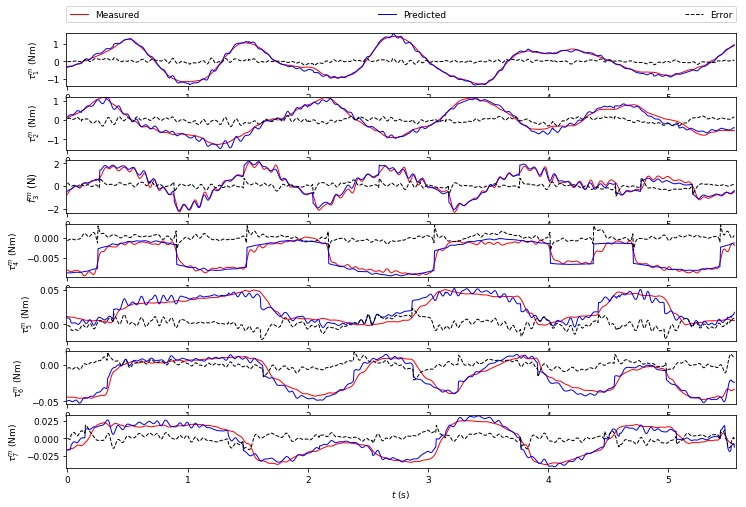

In [87]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [24]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_test[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.10271958, 0.18394008, 0.19826131, 0.13442613, 0.24024134,
       0.21187137, 0.26383741])

## Weighted Least Square (WLS)

### Training data set

In [25]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight

array([2.93727204, 3.01785995, 5.54867759, 0.01335894, 0.05668865,
       0.0581864 , 0.06459421])

In [26]:
W_b_train.shape, tau_s_train.shape

In [27]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [28]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [29]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [30]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [31]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

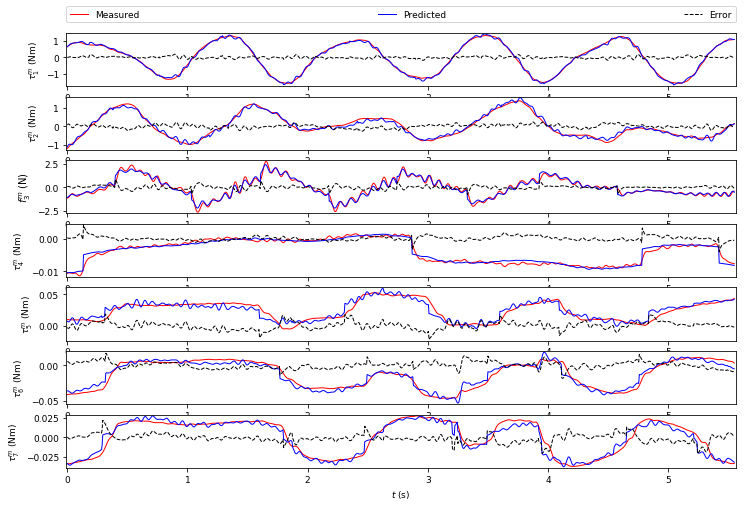

In [88]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type, 
                   robot_model.coordinates)

In [33]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.06594949, 0.1555572 , 0.1772842 , 0.13607351, 0.21066478,
       0.20960394, 0.25561636])

### Test data set

In [34]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)

# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [35]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.10278154, 0.18279762, 0.19762928, 0.13442613, 0.23987205,
       0.21112205, 0.26619204])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [36]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [37]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [38]:
sdp_constraints = []
spring_constraints = []

if model_name == 'psm':
    sdp_constraints = [(0.3, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, 1, 1, 0.2), #yaw_link
                      (0.3, 10, -0.1, 0.1, -0.2, 0.1, -0.05, 0.05, 1, 1, 0.2),    #Pitch Back
                      (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), #Intermediate
                      (0.1, 5, 0.1, 0.4, -0.06, 0.02, -0.03, 0.03, 1, 1, 0.2), #Pitch Bottom
                      (0.02, 2, 0.1, 0.4, -0.03, 0.03, -0.03, 0.03, 1, 1, 0.2), #Pitch Top
                      (0.1, 5, 0.0, 0.05, -0.40, 0.05, -0.03, 0.03, 1, 1, 0.2), #Pitch End
                      (0.01, 0.5, -0.05, 0.0, -0.14, 0.0, 0.02, 0.08, 1, 1, 0.2),  #Pitch Front
                      (0.1, 2, -0.02, 0.02, -0.02, 0.02, -0.1, 0.15, 1, 1, 1), #Main Insertion
                      (0.1, 2, -0.05, 0.05, -0.03, 0.03, -0.1, 0.1, 1, 1, 1), #Counterweight
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # Wrist Roll
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # Wrist Pitch
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # Wrist Yaw1
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # Wrist Yaw2
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # M6
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # M7
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1)] # F67
                       
    spring_constraints = [(0.0001, 1)]
    pass
else:
    raise Exception("No robot name matches " + model_name)

In [39]:


sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model,
                     sdp_constraints, spring_constraints)
# sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints)
%time sdp_opt_std.solve()

Regressor shape: (39193, 115)
Regressand shape: (39193,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 901736, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
Variables n = 116, constraints m = 39494
Cones:	linear vars: 131
	soc vars: 39195, soc blks: 1
	sd vars: 168, sd blks: 8
Setup time: 3.47e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf      -inf       inf  6.41e-02 


## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [40]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [89]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_sdp_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.06842904, 0.16282047, 0.17908605, 0.13606784, 0.21040285,
       0.20970335, 0.25597487])

### Plot measured torque and predicted torque

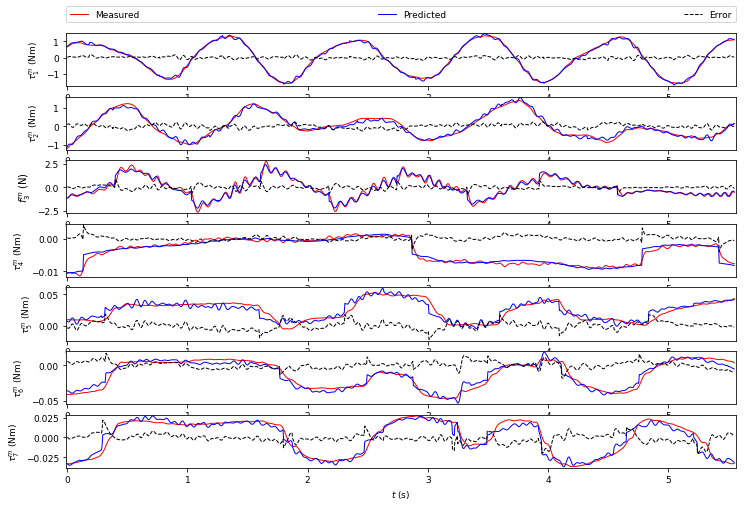

In [90]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on test set

In [43]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

In [66]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [91]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.09100187, 0.17859173, 0.18871233, 0.13446084, 0.23948912,
       0.2118872 , 0.2648028 ])

In [92]:
from identification import barycentric2standard_params

In [93]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)

In [94]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))

⎡I1xx   0.0970031390231438  ⎤
⎢                           ⎥
⎢I1xy   -0.010855523051537  ⎥
⎢                           ⎥
⎢I1xz  -1.03386020193045e-19⎥
⎢                           ⎥
⎢I1yy   0.0451446659757179  ⎥
⎢                           ⎥
⎢I1yz  -4.08337136929856e-19⎥
⎢                           ⎥
⎢I1zz  0.000769244366767562 ⎥
⎢                           ⎥
⎢r1x    0.0570380614808031  ⎥
⎢                           ⎥
⎢r1y    0.00946507563310179 ⎥
⎢                           ⎥
⎢r1z   -6.89862213357435e-21⎥
⎢                           ⎥
⎢ m₁     1.81088860522552   ⎥
⎢                           ⎥
⎢Fc₁    0.0493656348563117  ⎥
⎢                           ⎥
⎢Fv₁    0.0921020673131212  ⎥
⎢                           ⎥
⎢Fo₁    -0.200016475370082  ⎥
⎢                           ⎥
⎢I2xx   0.0243615866132382  ⎥
⎢                           ⎥
⎢I2xy   -0.018047120394499  ⎥
⎢                           ⎥
⎢I2xz   0.00574660920929281 ⎥
⎢                           ⎥
⎢I2yy   0.0202565339253737  ⎥
⎢         